## Imports

In [1]:
#PyTorch Specific libraries
# !pip install torchattacks
import torchattacks
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# For normalizing data
from sklearn import preprocessing

# Loading bar
from tqdm import tqdm

#reference for torchattacks: https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html
#reference for torch: https://pypi.org/project/torch/
#reference for torchvision: https://pypi.org/project/torchvision/
#reference for pandas: https://pandas.pydata.org/getting_started.html
#reference for numpy: https://numpy.org/doc/stable/user/absolute_beginners.html
#reference for matplotlib: https://matplotlib.org/2.0.2/users/pyplot_tutorial.html
#reference for math: https://docs.python.org/3/library/math.html
#reference for sklearn: https://scikit-learn.org/stable/getting_started.html
#reference for tqdm: https://pypi.org/project/tqdm/

## Data 

CIFAR10 dataset.

In [2]:
n_classes = 10
img_size  = 32
channel   = 3
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


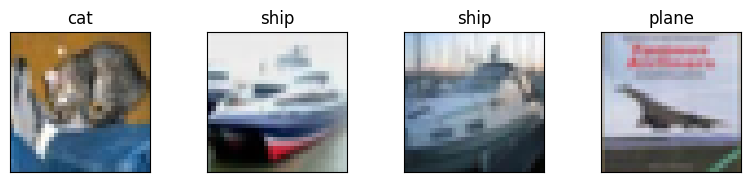

In [3]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# making sure we can view the images
images = images.detach().numpy()
images = [np.transpose(image, (1, 2, 0)) for image in images]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(classes[labels[idx].item()]))

## VGG-16 Architecture  

In [4]:
defaultcfg = {
    11 : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    13 : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512],
    16 : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],
    19 : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
}

def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),
        nn.ReLU()
    )
    return layer

class VGG16(nn.Module):
    def __init__(self, num_classes=10, **kwargs):
        super(VGG16, self).__init__()

        self.record = False
        self.targets = None
        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))

        # FC layers
        self.layer6 = vgg_fc_layer(512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = nn.Linear(4096, num_classes)


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        output_list = []
            
        out = self.layer1(x)
        output_list.append(out)
        
        out = self.layer2(out)
        output_list.append(out)
        
        out = self.layer3(out)
        output_list.append(out)
        
        out = self.layer4(out)
        output_list.append(out)
        
        vgg16_features = self.layer5(out)

        output_list.append(vgg16_features)

        out = self.avgpool(vgg16_features)

        out = out.view(out.size(0), -1)

        out = self.layer6(out)
        output_list.append(out)
        
        out = self.layer7(out)
        output_list.append(out)
        
        out = self.layer8(out)

        if self.record:
            self.record = False
            return out, output_list
        else:
            return out

## Model Loading

We used both the basic and robust pre-trained models and loaded here. The models are in the subfolder named /models/.

Reference: https://drive.google.com/file/d/1T1Ao-L16bM3eXZ6Pvk_y4UqVBImnC8Cg/view

In [5]:
basic_model = VGG16(num_classes=n_classes)
basic_model.load_state_dict(torch.load('./models/plain_vgg16_cifar10.pth',  map_location=torch.device('cpu')))

robust_model = VGG16(num_classes=n_classes)
robust_model.load_state_dict(torch.load('./models/AT_vgg16_cifar10.pth',  map_location=torch.device('cpu')))

<All keys matched successfully>

So far, we've imported the necessary libraries, loaded the CIFAR-10 dataset, implemented our VGG16 model, and created a test function to test the model's accuracy on the dataset below. We then evaluated the accuracy of both the basic model and the robust model.

In [6]:
def test(model):
    correct = 0
    total = 0

    model.eval()
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):

        # dataloader parsing and generate adversarial examples
        inputs, targets = inputs, targets

        # Evaluation
        outputs = model(inputs).detach()

        # Test
        _, predicted = torch.max(outputs, dim=1)
        total += targets.numel()
        correct += (predicted == targets).sum().item() 
    return 100.*correct / total

We test the pre-trained models on the CIFAR-10 test below and print their accuracy respectively. 

In [7]:
print('[Plain/Test] Accuracy: {:.3f}'.format(test(basic_model)))
print('[Plain/Test] Accuracy: {:.3f}'.format(test(robust_model)))



[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


[Plain/Test] Accuracy: 90.000


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]

[Plain/Test] Accuracy: 75.250


## 1. FGSM 

a) Execute the untargeted and targeted version of the FGSM attack. Use class cat (class index 3) as your target for the targeted version. Evaluate
the accuracy of the moeld.ns

In [8]:
#Untargeted attack adversary
def adv_test_untargeted(attack, net):
    correct = 0
    total = 0

    net.eval()
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
        inputs, targets = inputs, targets
        
        # dataloader parsing and generate adversarial examples
        adv_inputs = attack(inputs, targets)

        # Evaluation
        outputs = net(adv_inputs).detach()

        # Test
        _, predicted = torch.max(outputs, dim=1)
        total += targets.numel()
        correct += (predicted == targets).sum().item() 

        
    print('[Plain/Test] Accuracy: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

#Targeted attack adversary
def adv_test_targeted(attack, net):
    correct = 0
    total = 0

    net.eval()
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
        inputs, targets = inputs, targets
        
        # dataloader parsing and generate adversarial examples, target cat
        adv_inputs = attack(inputs, torch.full_like(targets, 3))

        # Evaluation
        outputs = net(adv_inputs).detach()

        # Test
        _, predicted = torch.max(outputs, dim=1)
        total += targets.numel()
        correct += (predicted == targets).sum().item() 

        
    print('[Plain/Test] Accuracy: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

In [19]:
# creating the FGSM attack instance for untargeted and targeted attack on the basic model
FGSM_attack_untargeted_basic = torchattacks.FGSM(basic_model, eps=8/255)
FGSM_attack_targeted_basic = torchattacks.FGSM(basic_model, eps=8/255)

# Testing with FGSM untargeted and targeted attacks on the basic model
adv_test_untargeted(FGSM_attack_untargeted_basic, basic_model)
adv_test_targeted(FGSM_attack_targeted_basic, basic_model)



[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


[Plain/Test] Accuracy: 11.490


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]

[Plain/Test] Accuracy: 79.550


79.55

b) Perform adversarial training using the FGSM attack. Then execute the untargeted and targeted version of the FGSM attack, same settings like in
part (a), but now on the adversarial trained model. Evaluate the accuracy of the model and compare results with part (a). 

We utilized a pretrained model as the adversarially trained model.

In [9]:
# FGSM attack instance for untargeted and targeted attack on the adversarially robust model
FGSM_attack_untargeted_robust = torchattacks.FGSM(robust_model, eps=8/255)
FGSM_attack_targeted_robust = torchattacks.FGSM(robust_model, eps=8/255)

# Testing FGSM untargeted and targeted attacks on the adversarially robust model
adv_test_untargeted(FGSM_attack_untargeted_robust, robust_model)
adv_test_targeted(FGSM_attack_targeted_robust, robust_model)





[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]


[Plain/Test] Accuracy: 46.650


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]

[Plain/Test] Accuracy: 72.440


72.44

## Bar Chart Visualization for the FGSM attacks

Basic - Untargeted: The accuracy is 11.49%, indicating the basic model was significantly effected by the attack, as most predictions were incorrect.

Basic - Targeted: Depicts the Attack Success Rate (ASR) for the basic model under targeted FGSM attacks, aimed at misclassifying inputs as a specific class (cat). An ASR of 79.55% indicates the attack was highly successful, with many inputs being misclassified as intended.

Robust - Untargeted: This shows the accuracy of the adversarially trained (robust) model under untargeted FGSM attacks. At 46.65%, the robust model shows considerably better resilience compared to the basic model, although the performance is still degraded from a clean scenario.

Robust - Targeted: Represents the ASR for the robust model under targeted FGSM attacks, with a rate of 72.44%. Although the robust model has better resistance compared to the basic model, the targeted attack remains relatively effective. 

For the bar chart presented below, the blue bars (untargeted) show the model's accuracy under attack.
The green bars (targeted) show the Attack Success Rate (ASR), with higher values indicating more successful attack.

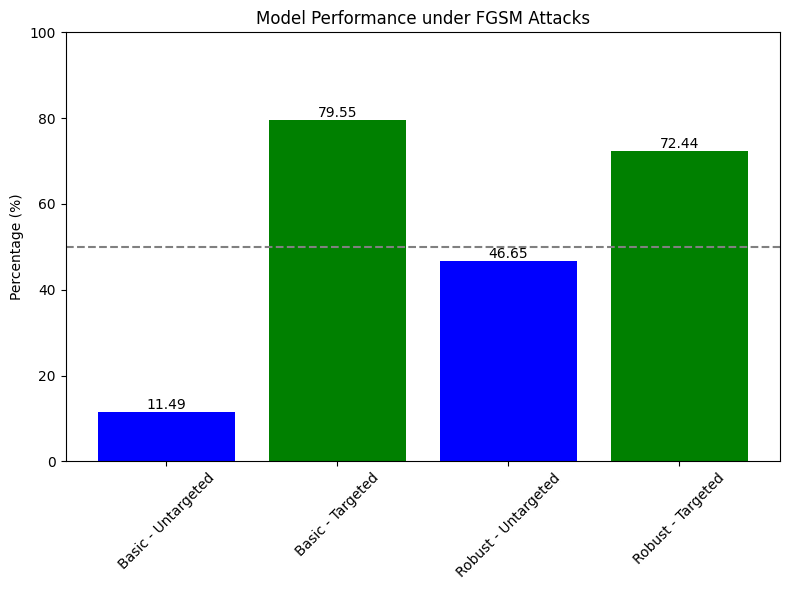

In [19]:
import matplotlib.pyplot as plt

#labels and values
labels = ['Basic - Untargeted', 'Basic - Targeted', 'Robust - Untargeted', 'Robust - Targeted']
# Untargeted values are accuracies; targeted values are ASRs
values = [11.490, 79.550, 46.650, 72.440] 

#blue for untargeted (accuracy), green for targeted (ASR)
colors = ['blue', 'green', 'blue', 'green']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

#value labels on top of each bar
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(value, 2), ha='center', va='bottom')

plt.ylim(0, 100)
plt.title('Model Performance under FGSM Attacks')
plt.ylabel('Percentage (%)')
plt.axhline(y=50, color='gray', linestyle='--') 
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

We were suprised by the small difference in success rate of our fooling between the basic and robust models against the targeted attack and we thought it may be due to the architecture we chose or the single epsilion value we placed. We tried with different epsilon values here below.

In [9]:
epsilon_values = [1/255, 4/255, 16/255]  

for eps in epsilon_values:
    print(f"\nTesting with epsilon: {eps}")
    
    # Basic model 
    print("\nTesting Basic Model:")
    FGSM_attack_untargeted_basic = torchattacks.FGSM(basic_model, eps=eps)
    FGSM_attack_targeted_basic = torchattacks.FGSM(basic_model, eps=eps)
    print("Untargeted Attack:")
    adv_test_untargeted(FGSM_attack_untargeted_basic, basic_model)
    print("Targeted Attack:")
    adv_test_targeted(FGSM_attack_targeted_basic, basic_model)

    # Robust model
    print("\nTesting Robust Model:")
    FGSM_attack_untargeted_robust = torchattacks.FGSM(robust_model, eps=eps)
    FGSM_attack_targeted_robust = torchattacks.FGSM(robust_model, eps=eps)
    print("Untargeted Attack:")
    adv_test_untargeted(FGSM_attack_untargeted_robust, robust_model)
    print("Targeted Attack:")
    adv_test_targeted(FGSM_attack_targeted_robust, robust_model)



Testing with epsilon: 0.00392156862745098

Testing Basic Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


[Plain/Test] Accuracy: 54.900
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


[Plain/Test] Accuracy: 85.840

Testing Robust Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


[Plain/Test] Accuracy: 71.740
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


[Plain/Test] Accuracy: 75.150

Testing with epsilon: 0.01568627450980392

Testing Basic Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


[Plain/Test] Accuracy: 18.100
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


[Plain/Test] Accuracy: 82.340

Testing Robust Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.57s/it]


[Plain/Test] Accuracy: 60.540
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


[Plain/Test] Accuracy: 73.920

Testing with epsilon: 0.06274509803921569

Testing Basic Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


[Plain/Test] Accuracy: 8.910
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


[Plain/Test] Accuracy: 69.290

Testing Robust Model:
Untargeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


[Plain/Test] Accuracy: 27.030
Targeted Attack:


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]

[Plain/Test] Accuracy: 70.200


Upon looking at the results, these seemed counter-intuitive to us that the success rate is dropping though we expected it to go higher as the perturbations get higher. 

One possibility is that it wasn't directly because of the usage of a single epsilon value, meaning the perturbation amount maybe made it harder to missclassify the images as our target class, and maybe the model classified them into other incorrect categories which led to this reduction in the targeted attack's success rate. We are not exactly sure.

# 2. PGD & Auto-PGD

Since the assignment description does not specify whether we should use the adversarially trained model or the basic model in this part, we chose the basic model to evaluate our attacks.

We utilized two functions we created earlier in the FGSM part of the assignment. The functions "adv_test_untargeted" and "adv_test_targeted" do not do anything specific other than taking any attack instance and a model as input, then performing the attack and evaluate the model's performance on the adversarial examples.

(a) Execute the untargeted version of the PGD and Auto-PGD attacks. Evaluate the results and compare both attacks in terms of success.

In [10]:
PGD_attack_base = torchattacks.PGD(basic_model, eps=8/255, alpha=1/255, steps=10, random_start=True)
print("Basic Model - Untargeted PGD Attack")
adv_test_untargeted(PGD_attack_base, basic_model)

APGD_attack_base = torchattacks.APGD(basic_model, eps=8/255, steps=10)
print("Basic Model - Untargeted Auto-PGD Attack")
adv_test_untargeted(APGD_attack_base, basic_model)

Basic Model - Untargeted PGD Attack


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:26<00:00, 11.07s/it]


[Plain/Test] Accuracy: 0.690
Basic Model - Untargeted Auto-PGD Attack


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:16<00:00, 12.17s/it]

[Plain/Test] Accuracy: 0.040


0.04

(b) Execute the targeted version of the PGD and Auto-PGD attacks. Evaluate the results and compare both attacks in terms of success. Use class
cat (class index 3) as your target.

In [11]:
print("Basic Model - Targeted PGD Attack")
adv_test_targeted(PGD_attack_base, basic_model)

# Auto-PGD - Targeted Attack Setup for Basic Model
APGD_attack_targeted_base = torchattacks.APGD(basic_model, eps=8/255, steps=10, loss='ce')
print("Basic Model - Targeted Auto-PGD Attack")
adv_test_targeted(APGD_attack_targeted_base, basic_model)


Basic Model - Targeted PGD Attack


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [21:26<00:00, 12.86s/it]


[Plain/Test] Accuracy: 81.510
Basic Model - Targeted Auto-PGD Attack


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.47s/it]

[Plain/Test] Accuracy: 83.040


83.04

(c) Explain why the PGD attack starts at a random point (rather than at the input point itself). Implement and execute the untargeted PGD attack
that starts at the input point. Compare the results with those of the untargeted PGD attack from part (a).

In [13]:
# PGD - Untargeted Attack starting at the input point for Basic Model
PGD_attack_base_input_start = torchattacks.PGD(basic_model, eps=8/255, alpha=1/255, steps=10, random_start=False)
print("Basic Model - Untargeted PGD Attack (Input Start)")
adv_test_untargeted(PGD_attack_base_input_start, basic_model)

Basic Model - Untargeted PGD Attack (Input Start)


[Plain/Test] Under Testing ... Please Wait


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:50<00:00, 11.31s/it]

[Plain/Test] Accuracy: 0.570


0.57

(d) Explain the difference between the PGD and Auto-PGD attacks. Which shortcomings of PGD have been improved by Auto-PGD?

Auto-PGD enhances PGD attack by taking an adaptive step size. This adjustment allows Auto-PGD to more effectively navigate the landscape, improving its ability to generate successful adversarial examples by adapting the step size based on the attack's progress and the specific input, leading to better performance in fooling the model in certain scenarios.

## Bar Chart Visualization for PGD and Auto-PGD attacks

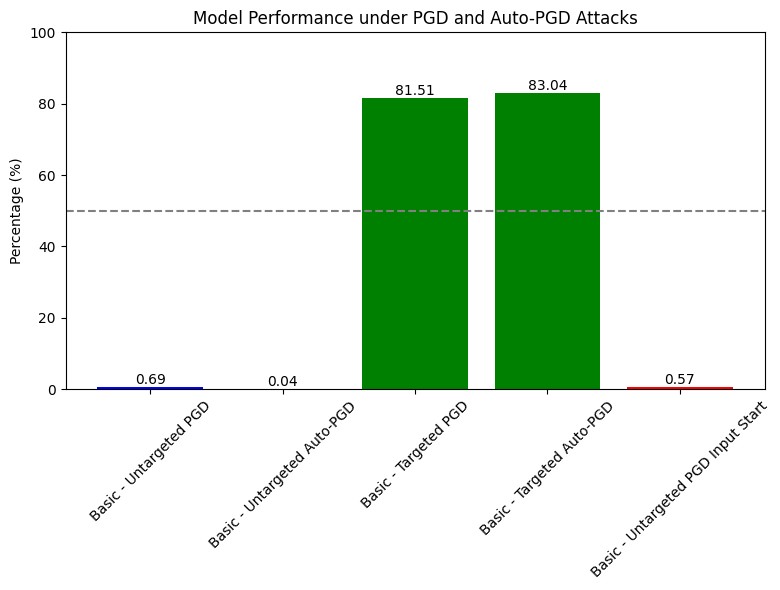

In [15]:
import matplotlib.pyplot as plt

#labels and values
labels = ['Basic - Untargeted PGD', 'Basic - Untargeted Auto-PGD', 'Basic - Targeted PGD', 'Basic - Targeted Auto-PGD', 'Basic - Untargeted PGD Input Start']
# Untargeted values are accuracies; targeted values are ASRs
values = [0.690, 0.040, 81.510, 83.040, 0.570] 

#blue for untargeted (accuracy), green for targeted (ASR)
colors = ['blue', 'blue', 'green', 'green', 'red']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

#value labels on top of each bar
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(value, 2), ha='center', va='bottom')

plt.ylim(0, 100)
plt.title('Model Performance under PGD and Auto-PGD Attacks')
plt.ylabel('Percentage (%)')
plt.axhline(y=50, color='gray', linestyle='--') 
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

## END